In [ ]:
import sys
sys.path.append("..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sympy import lambdify, Symbol
from sympy import pprint
from wire_modeling.preprocessing import load_point_cloud
from wire_modeling.clustering import cluster_wires
# from wire_modeling.clustering import segment_by_parallel_planes1, segment_by_parallel_planes2
# from wire_modeling.clustering import cluster_by_proximity
from wire_modeling.fitting import fit_catenary, compute_rmse_3d, project_cluster_to_best_plane, generate_catenary_equation_3d

file_path = "../data/lidar_cable_points_medium.parquet"

# df = pd.read_parquet(file_path)
df = load_point_cloud(file_path)

print("Shape:", df.shape)
print(df.dtypes)
print(len(df))
df.head()

Shape: (2803, 3)
x    float64
y    float64
z    float64
dtype: object
2803


,x,y,z
5117,8.927091,-17.271705,7.724551
3574,-0.514603,3.713301,6.604667
245,6.141806,-11.188338,10.438597
3258,6.998778,-10.146784,6.937106
5803,-7.537887,12.818930,7.195763


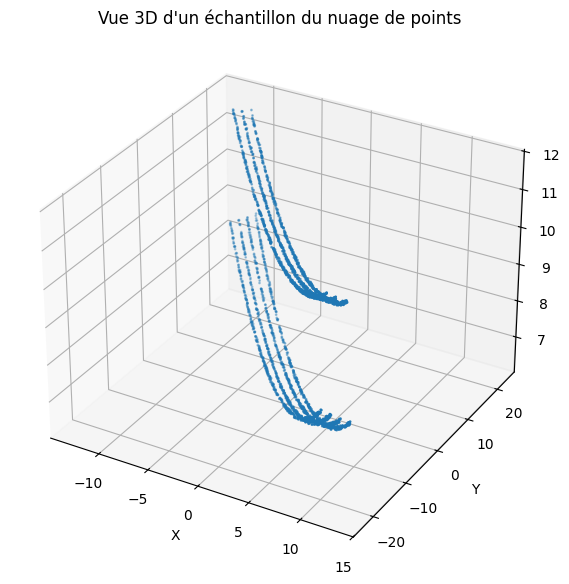

In [3]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['x'], df['y'], df['z'], s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title("Vue 3D d'un échantillon du nuage de points")
plt.show()

In [4]:
# points = df[['x', 'y']].values
# plt.scatter(points[:,0],points[:,1])

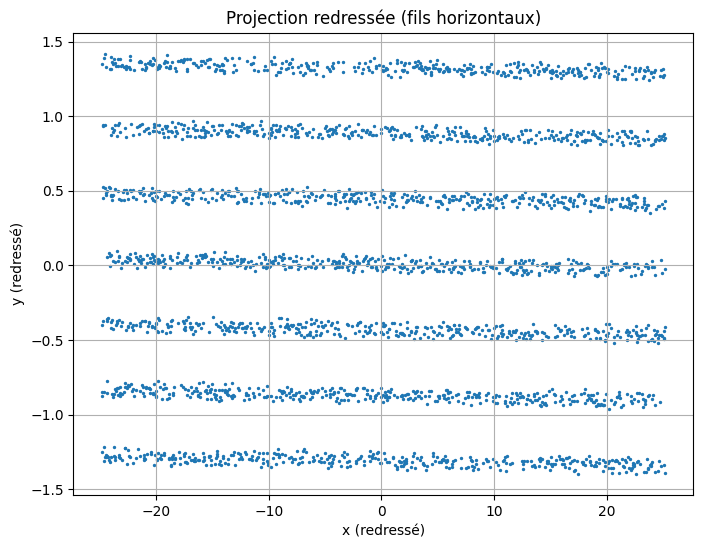

In [ ]:
points = df[['x', 'y']].values
center = points.mean(axis=0)
points_centered = points - center

pca = PCA(n_components=2)
pca.fit(points_centered)

# 1st principal axis (=wires "direction")
angle_rad = np.arctan2(pca.components_[0][1], pca.components_[0][0])
angle_deg = np.degrees(angle_rad)

# Reverse the angle to redress (negative rotation)
theta = -angle_rad
rotation_matrix = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta),  np.cos(theta)]
])

points_rotated = points_centered @ rotation_matrix.T

plt.figure(figsize=(8, 6))
plt.scatter(points_rotated[:, 0], points_rotated[:, 1], s=2)
plt.title("Redressed projection (horizontal wires)")
plt.xlabel("x (redressed)")
plt.ylabel("y (redressed)")
plt.grid(True)
plt.show()

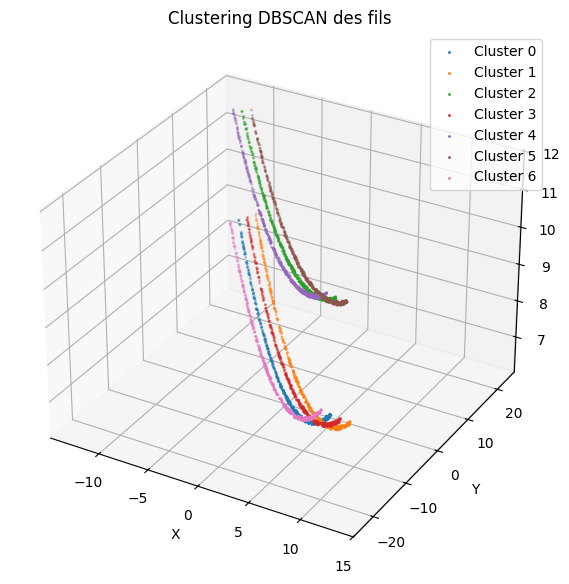

In [ ]:
labels = cluster_wires(df, eps=0.3, min_samples=10)
df['cluster'] = labels

# Clusters vizu
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

for label in np.unique(labels):
    cluster = df[df['cluster'] == label]
    ax.scatter(cluster['x'], cluster['y'], cluster['z'], s=1, label=f"Cluster {label}")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title("Wires DBSCAN Clustering")
plt.legend()
plt.show()

In [ ]:
# labels, projected_2d = segment_by_parallel_planes1(df, step=0.75, return_projected=True)
# df['cluster'] = labels
# labels, projected_2d = segment_by_parallel_planes2(df, step=0.25, z_tolerance=0.2, return_projected=True)
# df['cluster'] = labels

# labels = cluster_by_proximity(df, distance_threshold=0.75)
# df['cluster'] = labels

# # Vizualisation
# fig = plt.figure(figsize=(10, 7))
# ax = fig.add_subplot(111, projection='3d')

# for label in np.unique(labels):
#     cluster = df[df['cluster'] == label]
#     ax.scatter(cluster['x'], cluster['y'], cluster['z'], s=1, label=f"Cluster {label}")

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# plt.title("Plane-guided wire clustering (fixed)")
# plt.legend()
# plt.show()

In [8]:
# plt.scatter(projected_2d[:, 0], projected_2d[:, 1], c=labels, s=2, cmap="tab10")
# plt.xlabel("PCA axis 1")
# plt.ylabel("PCA axis 2")
# plt.grid()
# plt.title("Clusters in PCA-projected plane")
# plt.show()

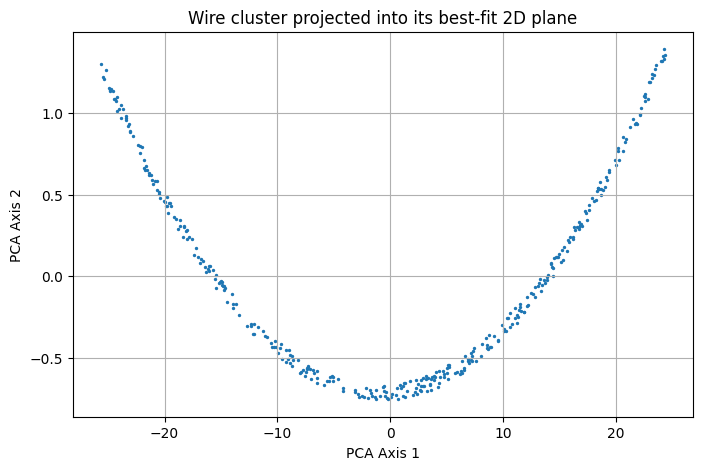

In [ ]:
# Test on 1 cluster
cluster_df = df[df['cluster'] == 6]
projected_2d, pca_model = project_cluster_to_best_plane(cluster_df)

# Vizu of the wire in his best fit plane

plt.figure(figsize=(8, 5))
plt.scatter(projected_2d[:, 0], projected_2d[:, 1], s=2)
plt.xlabel("PCA Axis 1")
plt.ylabel("PCA Axis 2")
plt.title("Wire cluster projected into its best-fit 2D plane")
plt.grid()
plt.show()

c:\Users\brice\Documents\GitHub\blunomy-env\blunomy-wire-modeling\notebooks\..\wire_modeling\fitting.py:32: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(catenary_function, x, y, p0=p0)


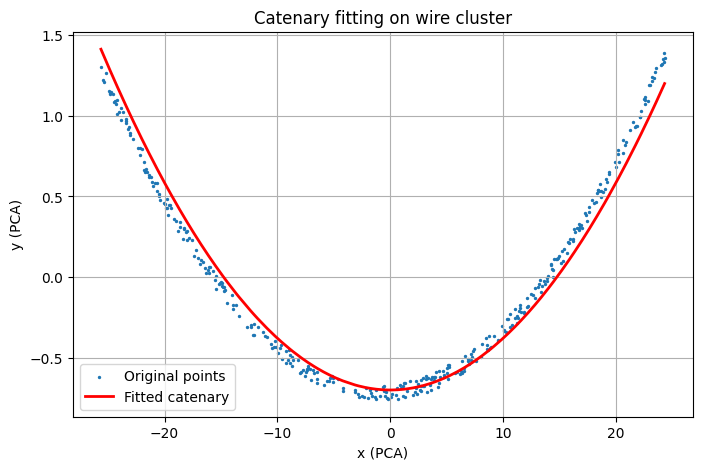

Fitted parameters [c, x0, y0] = [ 1.56049679e+02  2.23207142e-16 -1.56747917e+02]
RMSE of the fit: 0.0940


In [ ]:
x = projected_2d[:, 0]
y = projected_2d[:, 1]

params, y_fit = fit_catenary(x, y)

# Vizu
sort_idx = np.argsort(x)
x_sorted = x[sort_idx]
y_sorted = y_fit[sort_idx]

plt.figure(figsize=(8, 5))
plt.scatter(x, y, s=2, label="Original points")
plt.plot(x_sorted, y_sorted, color='red', label="Fitted catenary", linewidth=2)
plt.xlabel("x (PCA)")
plt.ylabel("y (PCA)")
plt.legend()
plt.title("Catenary fitting on wire cluster")
plt.grid()
plt.show()

print("Fitted parameters [c, x0, y0] =", params)

# Prediction evaluation : 
rmse = np.sqrt(np.mean((y - y_fit)**2))
print(f"RMSE of the fit: {rmse:.4f}")


In [11]:
# print(y_sorted)
# print(type(y_sorted))

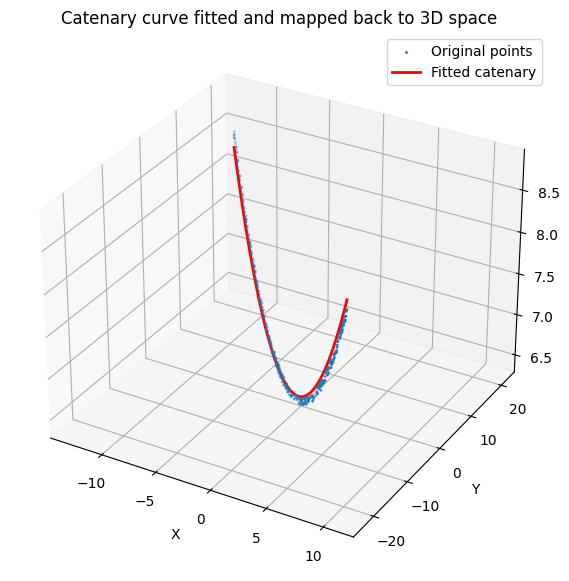

In [ ]:
# Reverse PCA to see the wire and the prediction in the original dimension
cat_2d = np.column_stack((x_sorted, y_sorted))    
cat_3d = pca_model.inverse_transform(
    np.column_stack((cat_2d, np.zeros_like(x_sorted)))  
)
mean = cluster_df[['x', 'y', 'z']].values.mean(axis=0)

# cat_3d is still centered → we shift
cat_3d_realigned = cat_3d + mean

# cat_2d = np.column_stack((x_sorted, y_sorted))
# cat_3d = pca_model.inverse_transform(np.column_stack((cat_2d, np.zeros_like(x_sorted))))

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Original points of the cluster
ax.scatter(cluster_df['x'], cluster_df['y'], cluster_df['z'], s=1, label="Original points")

# 3D catenary
ax.plot(cat_3d_realigned[:, 0], cat_3d_realigned[:, 1], cat_3d_realigned[:, 2], color='red', linewidth=2, label="Fitted catenary")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("Catenary curve fitted and mapped back to 3D space")
ax.legend()
plt.show()

In [ ]:
# RMSE in the original dimension
points_3d = cluster_df[['x', 'y', 'z']].values
rmse_3d = compute_rmse_3d(points_3d, cat_3d_realigned)
print(f"RMSE 3D: {rmse_3d:.3f} meters")

NameError: name 'cluster_df' is not defined

In [ ]:
# To see the equations

x_expr, y_expr, z_expr = generate_catenary_equation_3d(params, pca_model, mean)

print("Catenary 3D equation:")
print("x(x) ="); pprint(x_expr, use_unicode=True)
print("y(x) ="); pprint(y_expr, use_unicode=True)
print("z(x) ="); pprint(z_expr, use_unicode=True)

Catenary 3D equation:
x(x) =
-0.479536636788422⋅x - 0.246323672631568⋅cosh(0.00640821569230367⋅x - 1.430359 ↪

↪ 51079066e-18) - 1.1824900921239
y(x) =
0.877493565303855⋅x + 1.11851966283984⋅cosh(0.00640821569230367⋅x - 1.43035951 ↪

↪ 079066e-18) - 1.24977028831829
z(x) =
-0.00704676010500271⋅x + 156.045475645221⋅cosh(0.00640821569230367⋅x - 1.43035 ↪

↪ 951079066e-18) - 149.530610572802


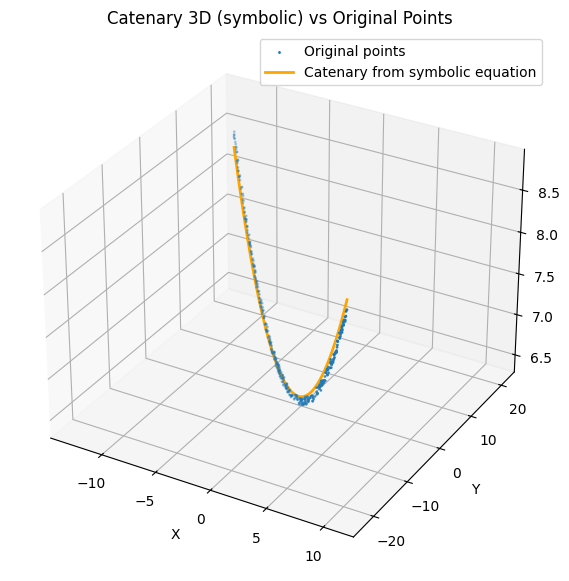

In [ ]:
# Plot the curve given by the equations
x_sym = Symbol('x')

fx = lambdify(x_sym, x_expr, modules=['numpy'])
fy = lambdify(x_sym, y_expr, modules=['numpy'])
fz = lambdify(x_sym, z_expr, modules=['numpy'])

x_vals = np.linspace(x_sorted.min(), x_sorted.max(), 100)
x_vals = x_vals.astype(float)  # Avoid sympy bugs

cat_x = fx(x_vals)
cat_y = fy(x_vals)
cat_z = fz(x_vals)

cat_curve_3d = np.vstack([cat_x, cat_y, cat_z]).T

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Original points of the cluster
ax.scatter(cluster_df['x'], cluster_df['y'], cluster_df['z'], s=1, label="Original points")

# 3D catenary
ax.plot(cat_curve_3d[:, 0], cat_curve_3d[:, 1], cat_curve_3d[:, 2],
        color='orange', label="Catenary from symbolic equation", linewidth=2)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title("Catenary 3D (symbolic) vs Original Points")
ax.legend()
plt.show()



3 wires detected in file: ../data/lidar_cable_points_extrahard.parquet


 CLUSTER 0 :
----------------------------------------
=> Number of points : 387
=> 3D Catenary Equation:
X(x) = 


c:\Users\brice\Documents\GitHub\blunomy-env\blunomy-wire-modeling\notebooks\..\wire_modeling\fitting.py:63: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(catenary_function, x, y, p0=p0)


-0.4787⋅x - 57.41⋅cosh(0.004985⋅x - 2.197e-18) + 56.79
Y(x) = 
0.878⋅x - 30.75⋅cosh(0.004985⋅x - 2.197e-18) + 30.05
Z(x) = 
-0.002523⋅x + 189.7⋅cosh(0.004985⋅x - 2.197e-18) - 179.7


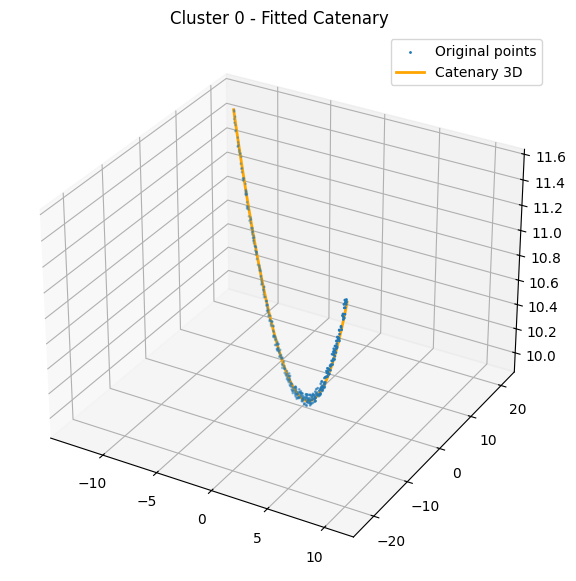

=> Catenary RMSE (3D)   : 0.1546 meters

 CLUSTER 1 :
----------------------------------------
=> Number of points : 397
=> 3D Catenary Equation:
X(x) = 
-0.4797⋅x - 43.97⋅cosh(0.004946⋅x + 9.738e-19) + 44.89
Y(x) = 
0.8775⋅x - 24.18⋅cosh(0.004946⋅x + 9.738e-19) + 24.34
Z(x) = 
0.0006458⋅x + 195.9⋅cosh(0.004946⋅x + 9.738e-19) - 185.9


c:\Users\brice\Documents\GitHub\blunomy-env\blunomy-wire-modeling\notebooks\..\wire_modeling\fitting.py:63: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(catenary_function, x, y, p0=p0)


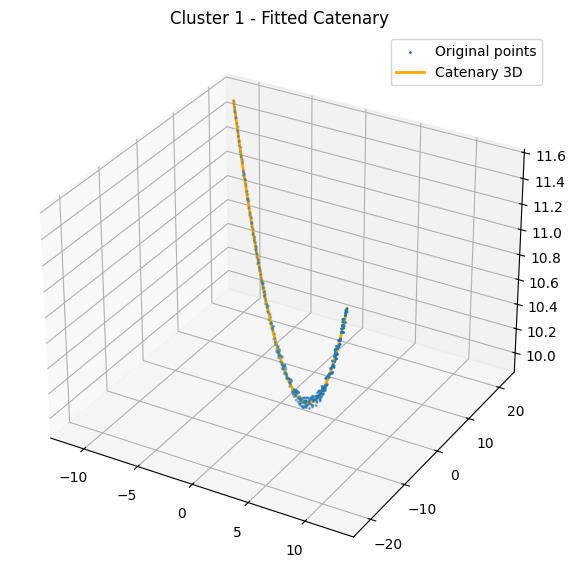

=> Catenary RMSE (3D)   : 0.1520 meters


c:\Users\brice\Documents\GitHub\blunomy-env\blunomy-wire-modeling\notebooks\..\wire_modeling\fitting.py:63: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(catenary_function, x, y, p0=p0)



 CLUSTER 2 :
----------------------------------------
=> Number of points : 417
=> 3D Catenary Equation:
X(x) = 
-0.4795⋅x - 25.8⋅cosh(0.004958⋅x + 6.759e-19) + 25.92
Y(x) = 
0.8776⋅x - 14.17⋅cosh(0.004958⋅x + 6.759e-19) + 13.94
Z(x) = 
0.0003303⋅x + 199.5⋅cosh(0.004958⋅x + 6.759e-19) - 189.5


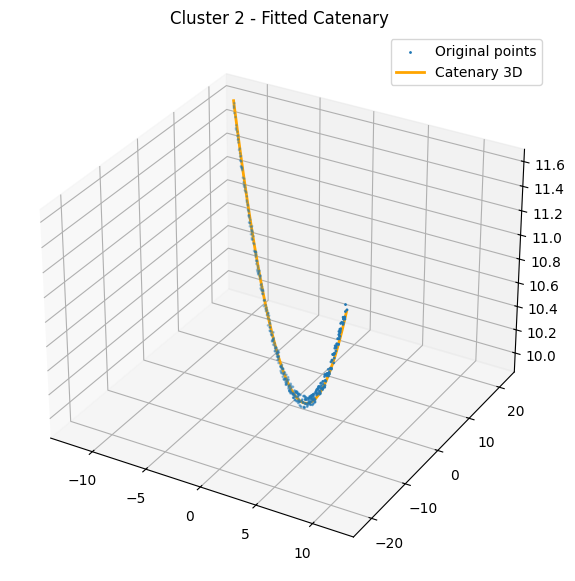

=> Catenary RMSE (3D)   : 0.1525 meters


In [ ]:
#Final try of the whole project
import sys
sys.path.append("..")
from wire_modeling.run_pipeline import process_lidar_file

process_lidar_file("../data/lidar_cable_points_extrahard.parquet")
